<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP_AE/MLP_AE_GBPUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.06 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 14:41:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'GBPUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP_AE'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 6.6 MB/s 
     |████████████████████████████████| 170 kB 58.5 MB/s 
     |████████████████████████████████| 138 kB 51.5 MB/s 
     |████████████████████████████████| 133 kB 49.5 MB/s 
     |████████████████████████████████| 97 kB 7.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 62 kB 914 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(RepeatVector(window_len))
    # layer 7
    model.add(Dense(32, activation=config.activation))
    # layer 8
    model.add(Dense(64, activation=config.activation))
    # layer 9
    model.add(Dense(128, activation=config.activation))
    # layer 10
    model.add(Flatten())
    # layer 11
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 7j1l8hme
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP_AE/sweeps/7j1l8hme


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: 7j34cuzf with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 17s 35ms/step - loss: 1.0671 - mean_squared_error: 1.0671 - mean_absolute_error: 0.7449 - val_loss: 0.6329 - val_mean_squared_error: 0.6329 - val_mean_absolute_error: 0.7180
Epoch 2/50
32/32 [==============================] - 0s 12ms/step - loss: 0.2683 - mean_squared_error: 0.2683 - mean_absolute_error: 0.3908 - val_loss: 0.0934 - val_mean_squared_error: 0.0934 - val_mean_absolute_error: 0.2534
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - mean_absolute_error: 0.2062 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0764
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0282 - mean_squared_error: 0.0282 - mean_absolute_error: 0.1137 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0619
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_erro

wandb: Agent Starting Run: jiye6m5y with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.0923 - mean_squared_error: 0.0923 - mean_absolute_error: 0.2021 - val_loss: 0.0481 - val_mean_squared_error: 0.0481 - val_mean_absolute_error: 0.1957
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1121 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0885
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - mean_absolute_error: 0.0761 - val_loss: 0.0331 - val_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.1519
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1071 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0987
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0113 - mean_squared_error: 

wandb: Agent Starting Run: 3he2nuos with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 97ms/step - loss: 0.1950 - mean_squared_error: 0.1950 - mean_absolute_error: 0.3550 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1094
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1162 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1415
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - mean_absolute_error: 0.0985 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0823
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0559 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0755
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037 -

wandb: Agent Starting Run: 9w203xti with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 51ms/step - loss: 0.2092 - mean_squared_error: 0.2092 - mean_absolute_error: 0.3195 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1748
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0867 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0769
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0391 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0777
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0367 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0806
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0024 - mean_squared_

wandb: Agent Starting Run: ae4vs5fg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 94ms/step - loss: 0.6651 - mean_squared_error: 0.6651 - mean_absolute_error: 0.6535 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0931
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0621 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1188
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0518 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1197
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0531 - val_loss: 0.0183 - val_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.1105
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0034 - mean_squared_error: 0.0034 -

wandb: Agent Starting Run: e2bz665j with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 48ms/step - loss: 173.1952 - mean_squared_error: 173.1952 - mean_absolute_error: 9.7281 - val_loss: 43.9054 - val_mean_squared_error: 43.9054 - val_mean_absolute_error: 6.5154
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 32.6731 - mean_squared_error: 32.6731 - mean_absolute_error: 4.9804 - val_loss: 30.9799 - val_mean_squared_error: 30.9799 - val_mean_absolute_error: 5.3516
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 28.9762 - mean_squared_error: 28.9762 - mean_absolute_error: 4.2534 - val_loss: 5.2861 - val_mean_squared_error: 5.2861 - val_mean_absolute_error: 2.1952
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 9.8476 - mean_squared_error: 9.8476 - mean_absolute_error: 2.6959 - val_loss: 3.7699 - val_mean_squared_error: 3.7699 - val_mean_absolute_error: 1.9261
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 13.7697 - 

wandb: Agent Starting Run: af1gcpm6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 53ms/step - loss: 166.2898 - mean_squared_error: 166.2898 - mean_absolute_error: 8.1527 - val_loss: 18.2445 - val_mean_squared_error: 18.2445 - val_mean_absolute_error: 4.0043
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 7.2517 - mean_squared_error: 7.2517 - mean_absolute_error: 2.1777 - val_loss: 1.4844 - val_mean_squared_error: 1.4844 - val_mean_absolute_error: 1.1717
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 7.2195 - mean_squared_error: 7.2195 - mean_absolute_error: 2.1511 - val_loss: 5.6907 - val_mean_squared_error: 5.6907 - val_mean_absolute_error: 2.2954
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.9186 - mean_squared_error: 1.9186 - mean_absolute_error: 1.0729 - val_loss: 0.0458 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1726
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.3555 - mean_squared

wandb: Agent Starting Run: hmb6d8p4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 51ms/step - loss: 8753.9266 - mean_squared_error: 8753.9266 - mean_absolute_error: 55.7945 - val_loss: 0.8934 - val_mean_squared_error: 0.8934 - val_mean_absolute_error: 0.4652
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 1.1436 - mean_squared_error: 1.1436 - mean_absolute_error: 0.5631 - val_loss: 1.8911 - val_mean_squared_error: 1.8911 - val_mean_absolute_error: 1.3060
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 109.5919 - mean_squared_error: 109.5919 - mean_absolute_error: 7.0994 - val_loss: 0.2267 - val_mean_squared_error: 0.2267 - val_mean_absolute_error: 0.4144
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 56.3915 - mean_squared_error: 56.3915 - mean_absolute_error: 2.4387 - val_loss: 0.6353 - val_mean_squared_error: 0.6353 - val_mean_absolute_error: 0.6495
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 280.2004 

wandb: Agent Starting Run: g2h818ma with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 32ms/step - loss: 1.6553 - mean_squared_error: 1.6553 - mean_absolute_error: 0.7023 - val_loss: 0.0868 - val_mean_squared_error: 0.0868 - val_mean_absolute_error: 0.2388
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0446 - mean_squared_error: 0.0446 - mean_absolute_error: 0.1606 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1584
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - mean_absolute_error: 0.1362 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1131
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1257 - val_loss: 0.0495 - val_mean_squared_error: 0.0495 - val_mean_absolute_error: 0.1867
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0216 - mean_squared_error:

wandb: Agent Starting Run: nlzrg5eo with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 51ms/step - loss: 0.0990 - mean_squared_error: 0.0990 - mean_absolute_error: 0.2323 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1012
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0692 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0715
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0400 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0690
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0325 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0596
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0020 - mean_squared_

wandb: Agent Starting Run: 51dfyqgj with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 53ms/step - loss: 25.6422 - mean_squared_error: 25.6422 - mean_absolute_error: 2.8273 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1719
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.2732 - mean_squared_error: 0.2732 - mean_absolute_error: 0.2718 - val_loss: 4.9432 - val_mean_squared_error: 4.9432 - val_mean_absolute_error: 2.1901
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 1.5224 - mean_squared_error: 1.5224 - mean_absolute_error: 0.8697 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1499
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 1.6278 - mean_squared_error: 1.6278 - mean_absolute_error: 0.7780 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1175
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0175 - mean_square

wandb: Agent Starting Run: ebds9tq5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.1174 - mean_squared_error: 0.1174 - mean_absolute_error: 0.2315 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0853
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0849 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0807
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - mean_absolute_error: 0.0754 - val_loss: 0.0099 - val_mean_squared_error: 0.0099 - val_mean_absolute_error: 0.0777
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0144 - mean_squared_error: 0.0144 - mean_absolute_error: 0.0887 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0847
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0108 - mean_squared_error: 

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gwfpuqfk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 3s 31ms/step - loss: 0.2484 - mean_squared_error: 0.2484 - mean_absolute_error: 0.4101 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.1981
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0793 - mean_squared_error: 0.0793 - mean_absolute_error: 0.2404 - val_loss: 0.0500 - val_mean_squared_error: 0.0500 - val_mean_absolute_error: 0.1984
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1990 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1675
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1670 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1455
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0248 - mean_squared_error: 

wandb: Agent Starting Run: swpzl684 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 48ms/step - loss: 13619.8195 - mean_squared_error: 13619.8195 - mean_absolute_error: 59.0647 - val_loss: 1.5253 - val_mean_squared_error: 1.5253 - val_mean_absolute_error: 1.0950
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.0032 - mean_squared_error: 1.0032 - mean_absolute_error: 0.7471 - val_loss: 0.7518 - val_mean_squared_error: 0.7518 - val_mean_absolute_error: 0.7323
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 19.4730 - mean_squared_error: 19.4730 - mean_absolute_error: 2.7310 - val_loss: 3.8802 - val_mean_squared_error: 3.8802 - val_mean_absolute_error: 1.8312
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 42.0046 - mean_squared_error: 42.0046 - mean_absolute_error: 4.2776 - val_loss: 165.7151 - val_mean_squared_error: 165.7151 - val_mean_absolute_error: 12.7956
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 947.0481 

wandb: Agent Starting Run: ixyjjlmb with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 3s 53ms/step - loss: 0.1690 - mean_squared_error: 0.1690 - mean_absolute_error: 0.3154 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1427
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0835 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0857
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0529 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0960
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0390 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0796
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0021 - mean_squared_

wandb: Agent Starting Run: mfwymshg with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 49ms/step - loss: 90.7829 - mean_squared_error: 90.7829 - mean_absolute_error: 3.7890 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1145
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0954 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1326
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1062 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1719
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1575 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_mean_absolute_error: 0.2306
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0366 - mean_squared_error

wandb: Agent Starting Run: kjukyfpk with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 29ms/step - loss: 0.1631 - mean_squared_error: 0.1631 - mean_absolute_error: 0.2680 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0766
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0416 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0688
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0518 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0679
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0579
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_error: 

wandb: Agent Starting Run: nldmjf9c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 4s 52ms/step - loss: 1.1308 - mean_squared_error: 1.1308 - mean_absolute_error: 0.8610 - val_loss: 0.1504 - val_mean_squared_error: 0.1504 - val_mean_absolute_error: 0.3418
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.2550 - mean_squared_error: 0.2550 - mean_absolute_error: 0.3784 - val_loss: 0.2964 - val_mean_squared_error: 0.2964 - val_mean_absolute_error: 0.4718
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.1490 - mean_squared_error: 0.1490 - mean_absolute_error: 0.2779 - val_loss: 0.5010 - val_mean_squared_error: 0.5010 - val_mean_absolute_error: 0.6660
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 0.1821 - mean_squared_error: 0.1821 - mean_absolute_error: 0.3231 - val_loss: 0.0691 - val_mean_squared_error: 0.0691 - val_mean_absolute_error: 0.2189
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0680 - mean_squared_error

wandb: Agent Starting Run: vol8uls9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 103ms/step - loss: 0.3036 - mean_squared_error: 0.3036 - mean_absolute_error: 0.4685 - val_loss: 0.1882 - val_mean_squared_error: 0.1882 - val_mean_absolute_error: 0.3568
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2172 - mean_squared_error: 0.2172 - mean_absolute_error: 0.3777 - val_loss: 0.1123 - val_mean_squared_error: 0.1123 - val_mean_absolute_error: 0.2537
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1294 - mean_squared_error: 0.1294 - mean_absolute_error: 0.2876 - val_loss: 0.0598 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1885
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0781 - mean_squared_error: 0.0781 - mean_absolute_error: 0.2451 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.2165
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0664 - mean_squared_error: 0.0664 

wandb: Agent Starting Run: 1jkrx0so with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 30ms/step - loss: 0.1378 - mean_squared_error: 0.1378 - mean_absolute_error: 0.2818 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - val_mean_absolute_error: 0.0996
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0499 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0763
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0373 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0792
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0342 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0739
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0018 - mean_squared_error:

wandb: Agent Starting Run: 8m6ivv08 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 51ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error

wandb: Agent Starting Run: q7hovb2u with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 46ms/step - loss: 0.7692 - mean_squared_error: 0.7692 - mean_absolute_error: 0.5833 - val_loss: 0.0486 - val_mean_squared_error: 0.0486 - val_mean_absolute_error: 0.1921
Epoch 2/100
16/16 [==============================] - 0s 9ms/step - loss: 0.2456 - mean_squared_error: 0.2456 - mean_absolute_error: 0.3643 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1164
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0692 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0730
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0573
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_err

wandb: Agent Starting Run: e3e9f1r5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 3s 26ms/step - loss: 16.0948 - mean_squared_error: 16.0948 - mean_absolute_error: 2.3273 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1322
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.4747 - mean_squared_error: 0.4747 - mean_absolute_error: 0.3043 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1371
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1328 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1624
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 4.2581 - mean_squared_error: 4.2581 - mean_absolute_error: 0.9441 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0881
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.1319 - mean_squared_error

wandb: Agent Starting Run: 7gxaw8xg with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 96ms/step - loss: 1.5574 - mean_squared_error: 1.5574 - mean_absolute_error: 1.0710 - val_loss: 0.3675 - val_mean_squared_error: 0.3675 - val_mean_absolute_error: 0.5896
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.3426 - mean_squared_error: 0.3426 - mean_absolute_error: 0.5133 - val_loss: 0.3292 - val_mean_squared_error: 0.3292 - val_mean_absolute_error: 0.5222
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2063 - mean_squared_error: 0.2063 - mean_absolute_error: 0.3888 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1086
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1422 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0969
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0172 - mean_squared_error: 0.0

wandb: Agent Starting Run: wruu3elu with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 98ms/step - loss: 147.6921 - mean_squared_error: 147.6921 - mean_absolute_error: 8.0023 - val_loss: 1.7739 - val_mean_squared_error: 1.7739 - val_mean_absolute_error: 1.1842
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 114.9003 - mean_squared_error: 114.9003 - mean_absolute_error: 7.3473 - val_loss: 137.6603 - val_mean_squared_error: 137.6603 - val_mean_absolute_error: 11.4053
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 70.7737 - mean_squared_error: 70.7737 - mean_absolute_error: 7.3281 - val_loss: 17.4621 - val_mean_squared_error: 17.4621 - val_mean_absolute_error: 3.8615
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 28.7424 - mean_squared_error: 28.7424 - mean_absolute_error: 4.8088 - val_loss: 53.1245 - val_mean_squared_error: 53.1245 - val_mean_absolute_error: 5.9921
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 42.6517 - m

wandb: Agent Starting Run: cfjeyxa0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 106ms/step - loss: 0.8781 - mean_squared_error: 0.8781 - mean_absolute_error: 0.6359 - val_loss: 0.1033 - val_mean_squared_error: 0.1033 - val_mean_absolute_error: 0.3030
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1376 - mean_squared_error: 0.1376 - mean_absolute_error: 0.2878 - val_loss: 0.3161 - val_mean_squared_error: 0.3161 - val_mean_absolute_error: 0.5140
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1742 - mean_squared_error: 0.1742 - mean_absolute_error: 0.3111 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1194
Epoch 4/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.1741 - val_loss: 0.0387 - val_mean_squared_error: 0.0387 - val_mean_absolute_error: 0.1768
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0480 - mean_squared_error: 0.0480 

wandb: Agent Starting Run: qse6st5x with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 54ms/step - loss: 142.8639 - mean_squared_error: 142.8639 - mean_absolute_error: 9.0038 - val_loss: 6.8741 - val_mean_squared_error: 6.8741 - val_mean_absolute_error: 2.3982
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 54.7841 - mean_squared_error: 54.7841 - mean_absolute_error: 6.0510 - val_loss: 116.5411 - val_mean_squared_error: 116.5411 - val_mean_absolute_error: 10.7396
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 55.1902 - mean_squared_error: 55.1902 - mean_absolute_error: 6.0514 - val_loss: 33.7234 - val_mean_squared_error: 33.7234 - val_mean_absolute_error: 5.2920
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 29.8774 - mean_squared_error: 29.8774 - mean_absolute_error: 4.6275 - val_loss: 13.3537 - val_mean_squared_error: 13.3537 - val_mean_absolute_error: 3.3335
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 27.8473 

wandb: Agent Starting Run: l14tqy33 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 50ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: n

wandb: Agent Starting Run: odtxmbn5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 91ms/step - loss: 0.6084 - mean_squared_error: 0.6084 - mean_absolute_error: 0.5851 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1010
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0658 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0644
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0408 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0609
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0347 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0601
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - mean_squared_error: 0.0018 -

wandb: Agent Starting Run: uandxplz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 3.0616 - mean_squared_error: 3.0616 - mean_absolute_error: 1.2692 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0751
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0821 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0573
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0287 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0587
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0332 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0431
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0012 - mean_squared_

wandb: Agent Starting Run: zo3628e9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 105ms/step - loss: 0.3086 - mean_squared_error: 0.3086 - mean_absolute_error: 0.4763 - val_loss: 0.2217 - val_mean_squared_error: 0.2217 - val_mean_absolute_error: 0.3987
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.2640 - mean_squared_error: 0.2640 - mean_absolute_error: 0.4275 - val_loss: 0.1851 - val_mean_squared_error: 0.1851 - val_mean_absolute_error: 0.3523
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.2282 - mean_squared_error: 0.2282 - mean_absolute_error: 0.3895 - val_loss: 0.1459 - val_mean_squared_error: 0.1459 - val_mean_absolute_error: 0.2989
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.1852 - mean_squared_error: 0.1852 - mean_absolute_error: 0.3457 - val_loss: 0.1094 - val_mean_squared_error: 0.1094 - val_mean_absolute_error: 0.2501
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.1373 - mean_squared_error: 0.1373 

wandb: Agent Starting Run: 0umpl102 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 3s 32ms/step - loss: 0.0918 - mean_squared_error: 0.0918 - mean_absolute_error: 0.2141 - val_loss: 0.0089 - val_mean_squared_error: 0.0089 - val_mean_absolute_error: 0.0772
Epoch 2/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0325 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0689
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0324 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0247 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0484
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 8.8732e-04 - mean_squared_e

wandb: Agent Starting Run: 6tactw4z with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 48ms/step - loss: 2.8397 - mean_squared_error: 2.8397 - mean_absolute_error: 1.0695 - val_loss: 0.0252 - val_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.1362
Epoch 2/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0715 - mean_squared_error: 0.0715 - mean_absolute_error: 0.1633 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1046
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1054 - val_loss: 0.2682 - val_mean_squared_error: 0.2682 - val_mean_absolute_error: 0.4847
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.4535 - mean_squared_error: 0.4535 - mean_absolute_error: 0.4685 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1055
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0149 - mean_squared_

wandb: Agent Starting Run: jgs3zylp with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 102ms/step - loss: 0.3189 - mean_squared_error: 0.3189 - mean_absolute_error: 0.4822 - val_loss: 0.2233 - val_mean_squared_error: 0.2233 - val_mean_absolute_error: 0.3997
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.2736 - mean_squared_error: 0.2736 - mean_absolute_error: 0.4376 - val_loss: 0.1850 - val_mean_squared_error: 0.1850 - val_mean_absolute_error: 0.3502
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.2356 - mean_squared_error: 0.2356 - mean_absolute_error: 0.3975 - val_loss: 0.1462 - val_mean_squared_error: 0.1462 - val_mean_absolute_error: 0.2973
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1878 - mean_squared_error: 0.1878 - mean_absolute_error: 0.3462 - val_loss: 0.1130 - val_mean_squared_error: 0.1130 - val_mean_absolute_error: 0.2535
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1460 - mean_squared_error: 0.

wandb: Agent Starting Run: lk0nphiw with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 4s 37ms/step - loss: 0.0761 - mean_squared_error: 0.0761 - mean_absolute_error: 0.1819 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1014
Epoch 2/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0490 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0705
Epoch 3/100
32/32 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0476 - val_loss: 0.0070 - val_mean_squared_error: 0.0070 - val_mean_absolute_error: 0.0680
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0555 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0617
Epoch 5/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0051 - mean_squared_

wandb: Agent Starting Run: yt94trvz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 3s 101ms/step - loss: 0.2224 - mean_squared_error: 0.2224 - mean_absolute_error: 0.3750 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1011
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0831 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1083
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - mean_absolute_error: 0.0910 - val_loss: 0.0095 - val_mean_squared_error: 0.0095 - val_mean_absolute_error: 0.0776
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0791 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0768
Epoch 5/50
8/8 [==============================] - 0s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047 

wandb: Agent Starting Run: naixnnnv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 3s 95ms/step - loss: 23.4999 - mean_squared_error: 23.4999 - mean_absolute_error: 2.4100 - val_loss: 0.1602 - val_mean_squared_error: 0.1602 - val_mean_absolute_error: 0.3888
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.1094 - mean_squared_error: 0.1094 - mean_absolute_error: 0.2758 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1830
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1655 - val_loss: 0.0451 - val_mean_squared_error: 0.0451 - val_mean_absolute_error: 0.1904
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1669 - val_loss: 0.0299 - val_mean_squared_error: 0.0299 - val_mean_absolute_error: 0.1478
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0330 - mean_squared_error: 0

wandb: Agent Starting Run: m8qdidgh with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 19588.1433 - mean_squared_error: 19588.1433 - mean_absolute_error: 69.3866 - val_loss: 1.0516 - val_mean_squared_error: 1.0516 - val_mean_absolute_error: 0.9447
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.8651 - mean_squared_error: 1.8651 - mean_absolute_error: 0.8776 - val_loss: 179.9320 - val_mean_squared_error: 179.9320 - val_mean_absolute_error: 13.4085
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 83.7832 - mean_squared_error: 83.7832 - mean_absolute_error: 7.6550 - val_loss: 25.1359 - val_mean_squared_error: 25.1359 - val_mean_absolute_error: 5.0103
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 62.0416 - mean_squared_error: 62.0416 - mean_absolute_error: 6.9758 - val_loss: 3.4958 - val_mean_squared_error: 3.4958 - val_mean_absolute_error: 1.8495
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 352.458

wandb: Agent Starting Run: 4mt3fdia with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(RepeatVector(window_len))
# layer 7
model.add(Dense(32, activation=best_config['activation']))
# layer 8
model.add(Dense(64, activation=best_config['activation']))
# layer 9
model.add(Dense(128, activation=best_config['activation']))
# layer 10
model.add(Flatten())
# layer 11
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  88769


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 960)           0         
_________________________________________________________________
dense_4 (Dense)              (None, 30, 32)            3

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 2s 6ms/step - loss: 0.1259
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0057
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0018
Epoch 5/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 6/100
20/20 [==============================] - 0s 6ms/step - loss: 0.0012
Epoch 7/100
20/20 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/100
20/20 [==============================] - 0s 5ms/step - loss: 8.3473e-04
Epoch 9/100
20/20 [==============================] - 0s 5ms/step - loss: 6.9388e-04
Epoch 10/100
20/20 [==============================] - 0s 5ms/step - loss: 8.5242e-04
Epoch 11/100
20/20 [==============================] - 0s 5ms/step - loss: 7.2883e-04
Epoch 12/100
20/20 [==============================] - 0s 5ms/step - loss: 7.9642e-04
Epoch 13/100
20/2

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

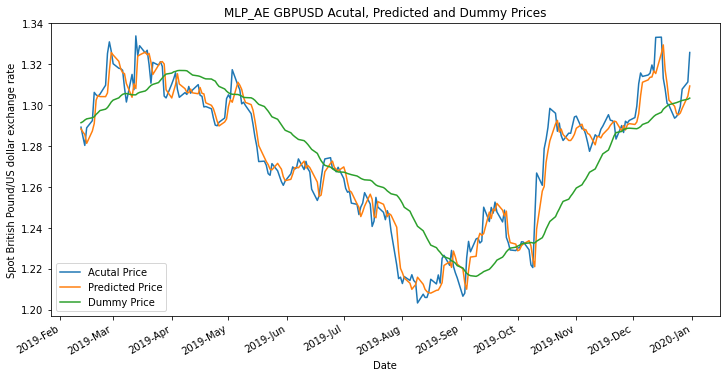

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

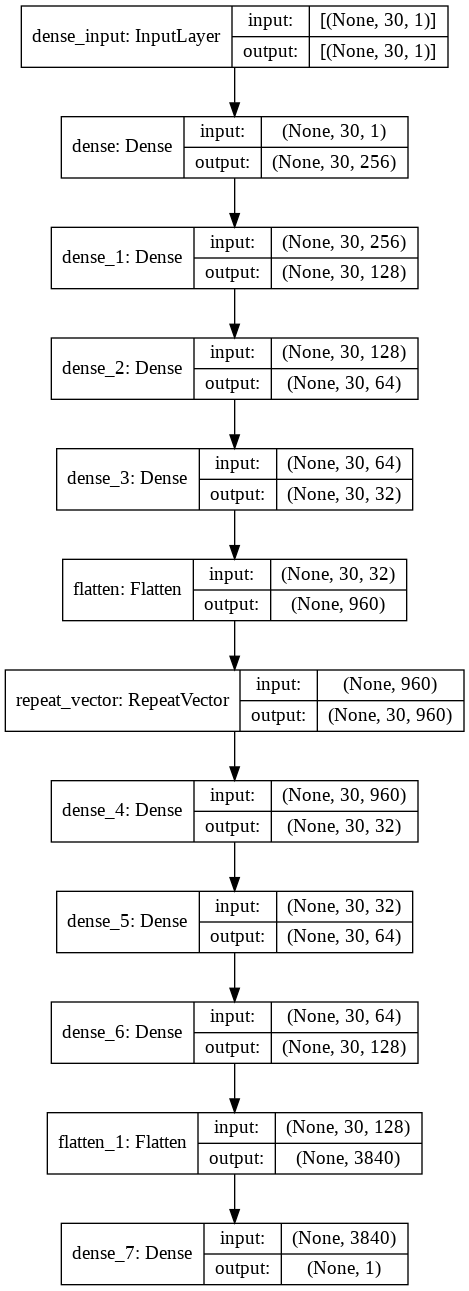

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003022565647139391
RMSE:  0.05497786506530961
MAE:  0.041234352579642315
Dummy MSE:  0.02193382943864584
Dummy RMSE:  0.14810074084435176
Dummy MAE:  0.1194927932858967


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_AE_GBPUSD/assets
